# Sports Dataset

10,000 random photos from soccer matches captured at a single timestamp make up the dataset. Every snapshot has a number of elements that offer details on the current match. The objective of the dataset is to capture the evolving dynamics of a soccer game, and to make predictions for the number of goals that will be scored for the remaining playing time.

# Dataset Structure

The dataset is presented in a single file with 10,000 rows and 20 columns, each row representing a snapshot of a soccer match, and each column representing a specific attribute or feature of that snapshot.

Number of Instances (Rows): 10,000 instances 
Number of Features (Columns): 20 features/columns 

# Feature Representation

The features include identifiers such as uuid, and dynamic match-related details such as the current minute of play, home and away team scores, yellow and red cards for both teams, the number of attacks and dangerous attacks by each team, corners awarded, shots on and off target for both teams, and the ball possession percentage for both the home and away teams until the current minute.

# Libraries

- pandas
- numpy
- matplotlib
- pickle
- os
- sklearn.metrics accuracy_score, classification_report, confusion_matrix
- sklearn.model_selection cross_val_predict, cross_val_score, train_test_split
- sklearn preprocessing 
- sklearn.linear_model LogisticRegression
- sklearn.model_selection GridSearchCV,train_test_split
- 

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import seaborn as sns
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [30]:
try:df = pd.read_csv(filepath_or_buffer = 'sports.csv', header = 0)
except:df = pd.read_csv(filepath_or_buffer = 'Dataset 3 - Sports Dataset/sports.csv', header = 0)
df

uuid  current_minute  home_score  \
0     2f9dd904-8d9d-4aa0-a9d9-4e0f3e50d742              94           1   
1     869c1420-9153-4d73-8d79-5db31a8a80a4              91           2   
2     549e25a3-4c93-459d-b115-fb303273c78a               3           0   
3     287b4be5-9163-4e2e-895d-d11052a97410              17           0   
4     a607da6a-d6b2-4652-b7a5-6c8e4b61c2b8              76           1   
...                                    ...             ...         ...   
6995  838f35c5-afa3-474b-876e-063fd49d4326              32           0   
6996  4bcfd248-5f39-4af2-b465-5358c9e7088e             101           3   
6997  deccdc2c-625e-495a-9b06-02d540d4cd24              78           1   
6998  94a20308-55d8-47cb-8f8b-d2702a531c74              72           2   
6999  0362876c-00dc-428f-a278-303d175a6ad2               8           0   

      away_score  home_yellow_cards  away_yellow_cards  home_red_cards  \
0              2                  0                  0               0   
1              0                  0                  0               0   
2              0                  0                  0               0   
3              0                  1                  0               0   
4              0                  1                  0               0   
...          ...                ...                ...             ...   
6995           0                  0                  0               0   
6996           0                  0                  1               0   
6997           0                  0                  0               0   
6998           0                  0                  0               0   
6999           0                  0                  0               0   

      away_red_cards  home_attacks  away_attacks  ...  away_dangerous_attacks  \
0                  0            39            45  ...                      26   
1                  0             0             0  ...                       0   
2                  0             3             1  ...                       0   
3                  0            41            46  ...                      25   
4                  0            69            78  ...                      46   
...              ...           ...           ...  ...                     ...   
6995               0            16            25  ...                      13   
6996               0             0             0  ...                       0   
6997               0            71            60  ...                      40   
6998               0            85            66  ...                      20   
6999               0             6            14  ...                       3   

      home_corners  away_corners  home_off_target  away_off_target  \
0                4             1                4                0   
1                0             0                0                0   
2                0             0                0                0   
3                1             0                0                2   
4                1             1                0                3   
...            ...           ...              ...              ...   
6995             0             1                1                2   
6996             0             0                0                0   
6997             7             0                5                5   
6998             3             0                4                1   
6999             0             0                0                0   

      home_on_target  away_on_target  home_possession  away_possession  \
0                  4               6               48               52   
1                  0               0               50               50   
2                  0               0               62               38   
3                  0               0               55               45   
4                  4               4               45               55   
..

# Data Preprocessing
Our objective for this project is to use the data given in the dataset to predict whether 1 or more goals can be scored in the remaining playing time of the match.

Remove Missing Data

In [31]:
df.dropna(inplace=True)

UUID is an unique identifier. no need to keep it.

In [32]:
try:
    df = df.drop(['uuid'], axis=1)
except:
    print('no uuid')

Use only data taken within the game time. Games last 105 minutes.  
Then remove any data from halftime. Halftime should be around minute 45 to minute 60. Because of that, starting minute 60, subtract them by 15 to make data contiguous.

In [33]:
df = df.query('0<= current_minute <= 105 ')
df = df.query('not (44 < current_minute <60)')
df['current_minute'] = df['current_minute'].apply(lambda x: x-15 if x > 45 else x)

<!-- df = df.groupby(df['current_minute'],as_index = False).aggregate('sum')
Aggregating was temptying but the samples became to small to use 
Feature Scaling
numerical_features = ['current_minute', 'home_score', 'away_score', 'home_yellow_cards', 'away_yellow_cards',
                      'home_red_cards', 'away_red_cards', 'home_attacks', 'away_attacks', 'home_dangerous_attacks',
                      'away_dangerous_attacks', 'home_corners', 'away_corners', 'home_off_target', 'away_off_target',
                      'home_on_target', 'away_on_target', 'home_possession', 'away_possession'] -->

In [34]:
# the target variable indicates whether 1 goal or more will be scored with the remaining time of the match. it shows binary values
df['target']= 0
df.loc[df['home_score'] + df['away_score']>0,'target'] = 1

X = df.drop(['target','home_score','away_score'], axis=1)
y = df['target']


In [35]:
# Current shape of our X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6577, 18)
Shape of y: (6577,)


# Exploratory Data Analysis

This is the content of the dataset

In [36]:
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


current_minute  home_score  away_score  home_yellow_cards  \
0              79           1           2                  0   
1              76           2           0                  0   
2               3           0           0                  0   
3              17           0           0                  1   
4              61           1           0                  1   

   away_yellow_cards  home_red_cards  away_red_cards  home_attacks  \
0                  0               0               0            39   
1                  0               0               0             0   
2                  0               0               0             3   
3                  0               0               0            41   
4                  0               0               0            69   

   away_attacks  home_dangerous_attacks  ...  home_corners  away_corners  \
0            45                      29  ...             4             1   
1             0                       0  ...             0             0   
2             1                       1  ...             0             0   
3            46                      11  ...             1             0   
4            78                      21  ...             1             1   

   home_off_target  away_off_target  home_on_target  away_on_target  \
0                4                0               4               6   
1                0                0               0               0   
2                0                0               0               0   
3                0                2               0               0   
4                0                3               4               4   

   home_possession  away_possession  final_delta  target  
0               48               52            1       1  
1               50               50            1       1  
2               62               38            4       0  
3               55               45            2       0  
4               45               55            0       1  

[5 rows x 21 columns]

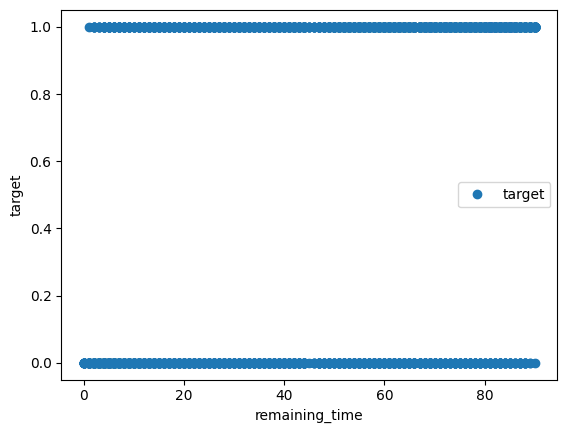

In [37]:
df.plot(x='current_minute', y='target', style='o')
plt.xlabel('remaining_time')
plt.ylabel('target')
plt.show()

Basic summary statistics for numerical values.  
Chart above shows that some snapshots had goals. Others had none. The data given does not have enough resolution to resolve when goals were made.

In [38]:
print("\nSummary statistics of numerical features:")
df.describe()


Summary statistics of numerical features:


current_minute   home_score   away_score  home_yellow_cards  \
count     6577.000000  6577.000000  6577.000000        6577.000000   
mean        49.804926     0.783032     0.608332           0.510263   
std         26.441958     1.068046     0.911459           0.907488   
min          0.000000     0.000000     0.000000           0.000000   
25%         27.000000     0.000000     0.000000           0.000000   
50%         55.000000     0.000000     0.000000           0.000000   
75%         72.000000     1.000000     1.000000           1.000000   
max         90.000000     8.000000     9.000000           8.000000   

       away_yellow_cards  home_red_cards  away_red_cards  home_attacks  \
count        6577.000000     6577.000000     6577.000000   6577.000000   
mean            0.592215        0.008515        0.014900     45.755968   
std             1.007297        0.093528        0.122412     36.029737   
min             0.000000        0.000000        0.000000      0.000000   
25%             0.000000        0.000000        0.000000     14.000000   
50%             0.000000        0.000000        0.000000     42.000000   
75%             1.000000        0.000000        0.000000     71.000000   
max             8.000000        2.000000        2.000000    255.000000   

       away_attacks  home_dangerous_attacks  ...  home_corners  away_corners  \
count   6577.000000             6577.000000  ...    6577.00000   6577.000000   
mean      42.857686               27.212863  ...       2.33161      1.971111   
std       33.539557               22.968335  ...       2.44227      2.192337   
min        0.000000                0.000000  ...       0.00000      0.000000   
25%       13.000000                7.000000  ...       0.00000      0.000000   
50%       40.000000               24.000000  ...       2.00000      1.000000   
75%       67.000000               42.000000  ...       4.00000      3.000000   
max      183.000000              132.000000  ...      14.00000     18.000000   

       home_off_target  away_off_target  home_on_target  away_on_target  \
count      6577.000000      6577.000000     6577.000000     6577.000000   
mean          3.016573         2.551163        2.136688        1.759313   
std           3.138122         2.719920        2.316965        2.002735   
min           0.000000         0.000000        0.000000        0.000000   
25%           0.000000         0.000000        0.000000        0.000000   
50%           2.000000         2.000000        2.000000        1.000000   
75%           5.000000         4.000000        3.000000        3.000000   
max          24.000000        18.000000       22.000000       19.000000   

       home_possession  away_possession  final_delta       target  
count      6577.000000      6577.000000  6577.000000  6577.000000  
mean         51.581572        48.415235     1.427855     0.649536  
std          10.542929        10.544736     1.423859     0.477151  
min           0.000000         0.000000    -2.000000     0.000000  
25%          46.000000        42.000000     0.000000     0.000000  
50%          51.000000        49.000000     1.000000     1.000000  
75%          58.000000        54.000000     2.000000     1.000000  
max         100.000000       100.000000    10.000000     1.000000  

[8 rows x 21 columns]

Scatterplot matrix for pairs of numerical features


Pairplot for numerical features:


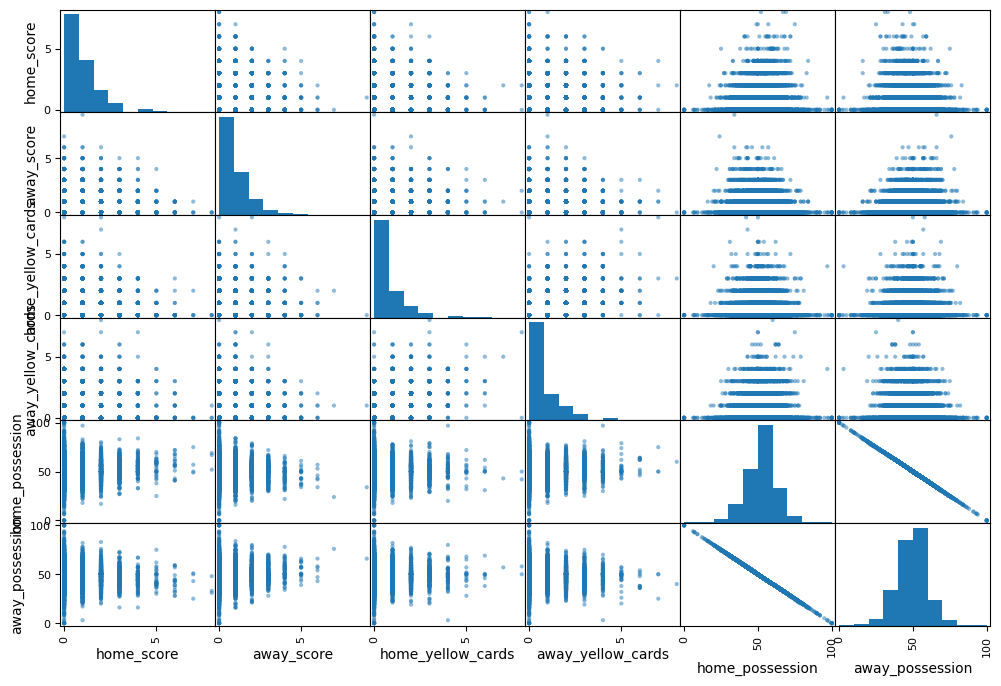

In [39]:
print("\nPairplot for numerical features:")
scatter_matrix = pd.plotting.scatter_matrix(df[['home_score', 'away_score', 'home_yellow_cards', 'away_yellow_cards', 'home_possession', 'away_possession']], figsize=(12, 8))
plt.show()

Histogram that shows the distribution of home and away scores


Distribution of home and away scores:


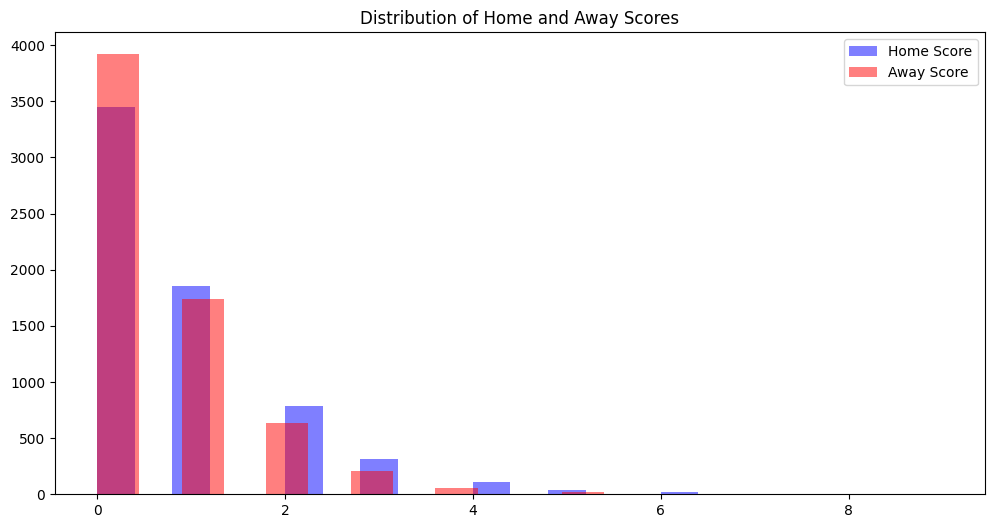

In [40]:
print("\nDistribution of home and away scores:")
plt.figure(figsize=(12, 6))
plt.hist(df['home_score'], bins=20, alpha=0.5, label='Home Score', color='blue')
plt.hist(df['away_score'], bins=20, alpha=0.5, label='Away Score', color='red')
plt.title('Distribution of Home and Away Scores')
plt.legend()
plt.show()

# Data set splitting

In [41]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale the data sets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# split train data to test and validation sets equally
# train data will train the initial  model
# validation will be used to find the best hyper parameters
X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# Helpers
The cells below contain functions that will help with displaying things later

In [42]:
# predictions: model predictions
# actual: the actual labels
#mode: type of data set evaluated
def show_metrics(true,predictions,mode = "Train"):
    
    accuracy = accuracy_score(true,predictions)
    conf_matrix = confusion_matrix(true,predictions)
    classification_rep = classification_report(true,predictions)
    
    print(f"\n{mode} Accuracy:", accuracy)
    print(f"{mode} Confusion Matrix:\n", conf_matrix)
    print(f"{mode} Classification Report:\n", classification_rep)
    return accuracy, conf_matrix,classification_rep

In [43]:
def show_mat(mat,title = "Confusion Matrix"):
    fig, axes = plt.subplots(1, 1, figsize=(12, 4))
    
    # Confusion Matrix
    sns.heatmap(mat, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes)
    axes.set_xlabel('Predicted')
    axes.set_ylabel('True')
    axes.set_title(title)
    
    plt.show()

# Decision Tree Classifier

This time let's see how Random Forest will classify this.

In [44]:
# Instantiate Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=42)

# Train the model on the training set
decision_tree.fit(X_train_1, y_train_1)

DecisionTreeClassifier(random_state=42)

Let's see how well it performs on validation set

In [45]:
# Make predictions on the validation set
y_val_pred = decision_tree.predict(X_val)

# Evaluate the model on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)
class_report = classification_report(y_val, y_val_pred)

Validation Accuracy: 0.7004038964124495
Validation Confusion Matrix:
 [[ 912  581]
 [ 680 2036]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.61      0.59      1493
           1       0.78      0.75      0.76      2716

    accuracy                           0.70      4209
   macro avg       0.68      0.68      0.68      4209
weighted avg       0.71      0.70      0.70      4209



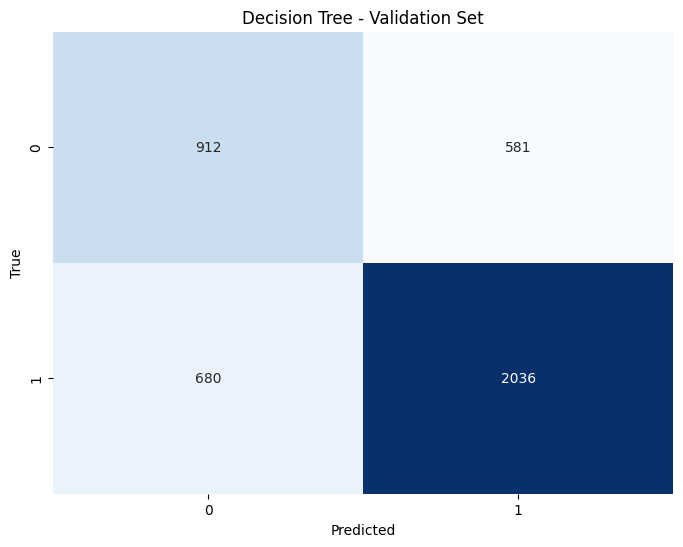

In [46]:
# Display evaluation metrics
print("Validation Accuracy:", accuracy)
print("Validation Confusion Matrix:\n", conf_matrix)
print("Validation Classification Report:\n", class_report)

# Visualize Confusion Matrix
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes)
axes.set_xlabel('Predicted')
axes.set_ylabel('True')
axes.set_title('Decision Tree - Validation Set')
plt.show()

With an accuracy of ~70%, an f1 score of 0.59 for class 0 given the number of misclassifications to class 0 when it should have been class 1.
Misclassifying class 0 is less prevalent but it is still sizeable. Initial model is not the best.

In [49]:
# Make predictions on the test set
y_test_pred = decision_tree.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_class_report = classification_report(y_test, y_test_pred)

Test Accuracy: 0.7226443768996961
Test Confusion Matrix:
 [[290 147]
 [218 661]]
Test Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.66      0.61       437
           1       0.82      0.75      0.78       879

    accuracy                           0.72      1316
   macro avg       0.69      0.71      0.70      1316
weighted avg       0.74      0.72      0.73      1316



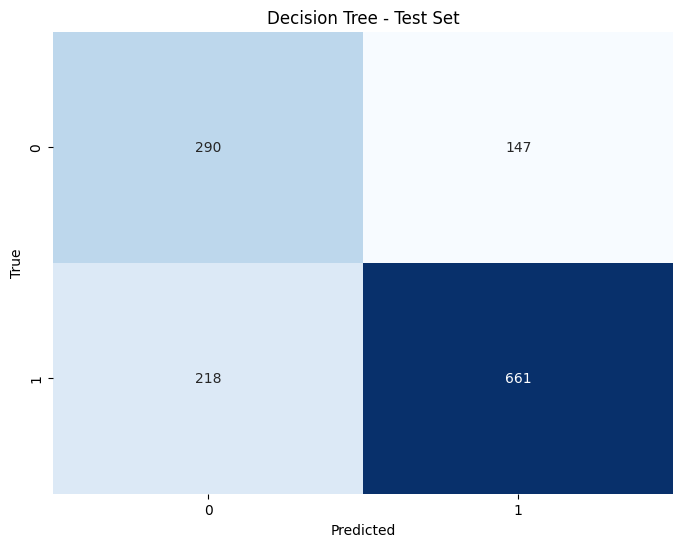

In [48]:
# Display evaluation metrics for the test set
print("Test Accuracy:", test_accuracy)
print("Test Confusion Matrix:\n", test_conf_matrix)
print("Test Classification Report:\n", test_class_report)

# Visualize Confusion Matrix for the test set
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes)
axes.set_xlabel('Predicted')
axes.set_ylabel('True')
axes.set_title('Decision Tree - Test Set')
plt.show()

Similar story in test set. There must be something that causes it to fit more to class 0.

Let's try to make the model better. We will use the Validation set  to train it since we already used the training data. using randomized search to save time

In [53]:
from scipy.stats import randint

d_hpg = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

In [54]:
r_dtc = RandomizedSearchCV(decision_tree,d_hpg,scoring = 'f1', n_jobs = -1,refit = True,random_state =42)

In [55]:
r_dtc.fit(X_val,y_val)

C:\Users\shawn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\shawn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shawn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\shawn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py"

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BC680AD0D0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BC67982010>,
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='f1')

In [56]:
r_dtc.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=30, min_samples_leaf=15,
                       min_samples_split=16, random_state=42,
                       splitter='random')

Okay, those are the hyperparameters we got. let's see if the training went well first. let's evaluate on validation set


Train Accuracy: 0.8063673081492041
Train Confusion Matrix:
 [[ 913  580]
 [ 235 2481]]
Train Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.61      0.69      1493
           1       0.81      0.91      0.86      2716

    accuracy                           0.81      4209
   macro avg       0.80      0.76      0.78      4209
weighted avg       0.81      0.81      0.80      4209



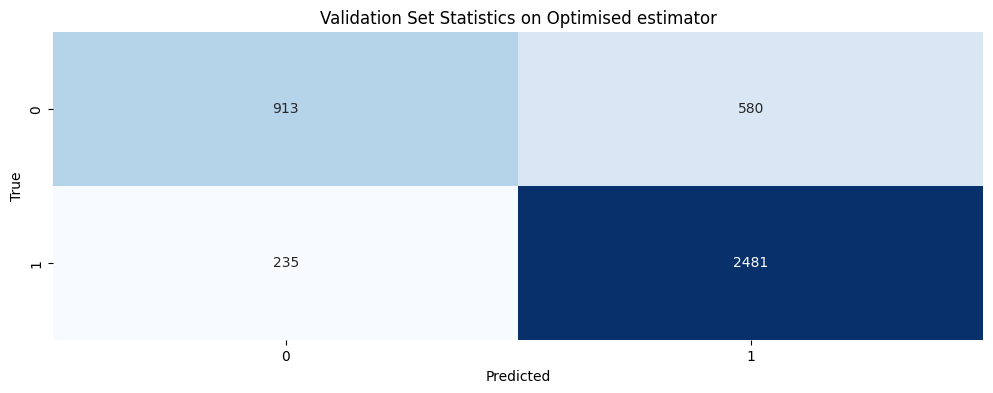

In [59]:
p_val = r_dtc.predict(X_val)
metrics = show_metrics(y_val,p_val, 'Train')
show_mat(metrics[1], "Validation Set Statistics on Optimised estimator")

Doing better. accuracy is now ~80%. F1 score for class 1 and class 0 also improved but for some reason, it still likes to misclassify 1 as a 0 sometimes. Not as often as before atleast

Let's take do the real test.


Test Accuracy: 0.7849544072948328
Test Confusion Matrix:
 [[250 187]
 [ 96 783]]
Test Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.57      0.64       437
           1       0.81      0.89      0.85       879

    accuracy                           0.78      1316
   macro avg       0.76      0.73      0.74      1316
weighted avg       0.78      0.78      0.78      1316



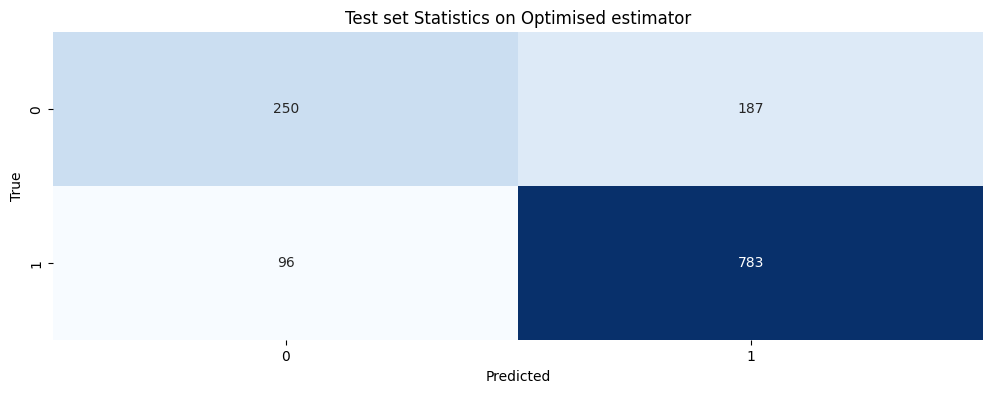

In [61]:
p_val = r_dtc.predict(X_test)
metrics = show_metrics(y_test,p_val, 'Test')
show_mat(metrics[1], "Test set Statistics on Optimised estimator")

Marginally more accurate(~72% for unoptimised, ~78% optimised). same goes for F1 score on both classes.